In [58]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [59]:
# Upload the data
X_train = pd.read_csv('data/processed/X_train.csv', index_col=0)
X_test = pd.read_csv('data/processed/X_test.csv', index_col=0)
y_train = pd.read_csv('data/processed/y_train.csv', index_col=0)
y_test = pd.read_csv('data/processed/y_test.csv', index_col=0)

In [60]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55025 entries, 2905 to 78034
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          55025 non-null  float64
 1   UGDS               55025 non-null  float64
 2   TUITFTE            55025 non-null  float64
 3   INEXPFTE           55025 non-null  float64
 4   PFTFAC             55025 non-null  float64
 5   UG25abv            55025 non-null  float64
 6   COMP_ORIG_YR4_RT   55025 non-null  float64
 7   WDRAW_ORIG_YR4_RT  55025 non-null  float64
 8   ENRL_ORIG_YR4_RT   55025 non-null  float64
 9   DEBT_MDN           55025 non-null  float64
 10  Year               55025 non-null  float64
 11  Cost               55025 non-null  float64
 12  Complete           55025 non-null  float64
 13  RetentionFT        55025 non-null  float64
 14  PREDDEG_1          55025 non-null  float64
 15  PREDDEG_2          55025 non-null  float64
 16  PREDDEG_3          

In [61]:
y_train.head()

,CURROPER
10080,True
52173,True
21080,True
53090,True
65675,True


In [62]:
y = y_train.CURROPER.ravel()

# Modeling
## Logistic Regression

Hyperparameters to tune:
- C = inverse of regularization strength; smaller values are stronger regularization, may lead to underfit model; large C may lead to overfitting
- l1_ratio = 0 == L2 penalty; 1 == L1 penalty

In [63]:
# Import and instantiate model
from sklearn.linear_model import LogisticRegression

In [64]:
# Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV

c_grid = [0.001, 0.01, 0.1, 1, 10]
l1_ratio_grid = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
max_iter_grid = [100, 500, 1000, 1500, 2000]

lr_grid = {'C':c_grid, 'l1_ratio':l1_ratio_grid,'max_iter':max_iter_grid}

In [65]:
logreg = LogisticRegression(solver = 'saga', penalty = 'elasticnet')
logreg_cv = RandomizedSearchCV(logreg, lr_grid, cv=5)

In [66]:
start= time.time()
logreg_cv.fit(X_train, y)
end = time.time()
print('GridSearch Time:', end-start)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

GridSearch Time: 403.1945447921753


In [67]:
print("Best params: " , logreg_cv.best_params_)
print("Best score: ", logreg_cv.best_score_)

Best params:  {'max_iter': 2000, 'l1_ratio': 0, 'C': 0.001}
Best score:  0.8531940027260336


### Grid Results
- Original run: l1_ratio=0.25, max_iter=2000, C=0.001
- Second run: l1_ratio=1, max_iter= 2000, C=0.001
- Third run: l1_ratio = 0.1, max_iter = 2000, C=0.01
- Another run: l1_ratio = 0, max_iter = 1000, C=0.001

### Run the model with the best parameters

In [68]:
modelLR = LogisticRegression(C = 0.01, penalty = 'elasticnet', l1_ratio=0, max_iter = 2000, solver = 'saga')
start = time.time()
modelLR.fit(X_train, y)
end = time.time()
print("Fit time = ", end - start)

start = time.time()
lr_pred = modelLR.predict(X_test)
end = time.time()
print("Predict time = ", end - start)

lr_pred_prob = modelLR.predict_proba(X_test)[:, 1]

Fit time =  9.760247945785522
Predict time =  0.001850128173828125


### Evaluate the model

In [69]:
# Evaluate model
# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, lr_pred))

[[   86  3380]
 [  120 19997]]


In [70]:
# Classification report
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

       False       0.42      0.02      0.05      3466
        True       0.86      0.99      0.92     20117

    accuracy                           0.85     23583
   macro avg       0.64      0.51      0.48     23583
weighted avg       0.79      0.85      0.79     23583



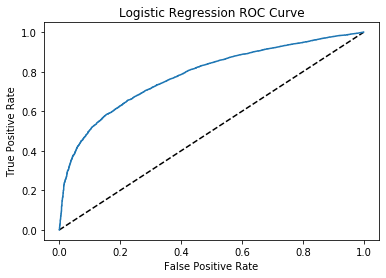

In [71]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, lr_pred_prob)

plt.plot( [0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [72]:
print("AUC: ", roc_auc_score(y_test, lr_pred_prob))

AUC:  0.7829553000693205


In [73]:
# Coefficients
coeffic = modelLR.coef_
coeffic = coeffic[0]
labels = [i for i in X_train.columns]
numLab = len(labels)

In [74]:
coeffic = pd.DataFrame(coeffic, index=labels)
coeffic.columns= ['Coefficient']
coeffic.sort_values(by='Coefficient', inplace=True, ascending=False)
coeffic.head()

,Coefficient
UGDS,0.864991
Year,0.493708
PREDDEG_3,0.370470
Complete,0.121109
DEBT_MDN,0.113767


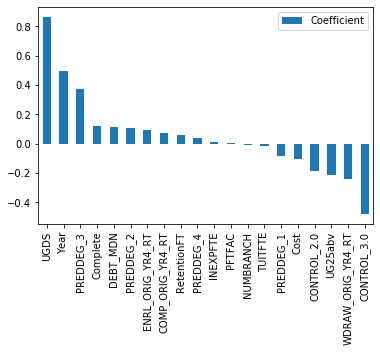

In [75]:
coeffic.plot.bar(y='Coefficient')
#plt.xticks(range(0, numLab), labels, rotation='vertical')
plt.show()

### Coefficient comments
- UGDS = Undergraduate enrollment - seems to be the most important predictor, but it's worth checking how many values were imputed.
- Year probably shouldn't be a predictor variable - it was included to distinguish the same schools across different years, to see at which point schools closed.
- Preddeg3 = Schools that offer predominantly bachelor's degrees (I think). I think this was the largest group of schools, so it may just be a data balance size issue. (May be predominantly graduate degrees)

- Negative coefficient values
-- Control3 = Private for-profit school
-- Control2 = Private nonprofit
--(So does this mean that public schools have no effect, or positive coeff value?)
- Withdraw
- UG25abv 

## Decision Tree
Parameters to search:
- max_features
- max_depth
- min_samples_leaf

In [19]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import RandomizedSearchCV

In [20]:
criterion_grid = ['gini', 'entropy']
max_depth_grid = ['None', 3, 5, 10, 20, 50, 75, 100]
min_sample_split_grid = [2, 5, 10, 25, 50, 75, 100]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

dtc_grid = {'criterion': criterion_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [21]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, dtc_grid, cv=5)
tree_cv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [22]:
print("Best params: " , tree_cv.best_params_)
print("Best score: ", tree_cv.best_score_)

Best params:  {'min_samples_split': 2, 'min_samples_leaf': 50, 'max_features': 15, 'max_depth': 50, 'criterion': 'gini'}
Best score:  0.8715129486597002


### Grid Search Results
- First run: min_sample_split=2; min_samples_leaf=25; max_features=20, max_depth=20, criterion=entropy
- Second run: min_sample_split=75, min_samples_leaf=25; max_features=20, max_depth=20, criterion='entropy'
- Another run: min_sample_split=100; min_samples_leaf=25; max_features=15; max_depth=50; criterion = entropy

### Explore just the criterion and max_depth features, leaving the other arguments as the default. Plot the accuracy of different tree depths using both criterion measures.
Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [54]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

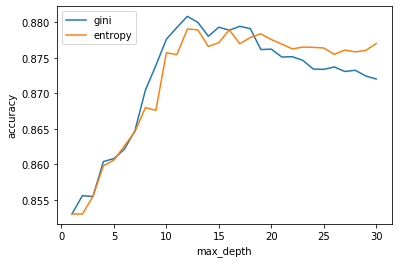

In [57]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
#plt.vlines(12, 0.855, 0.880)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [25]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion='gini', max_depth=12)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.342593 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.342593 to fit



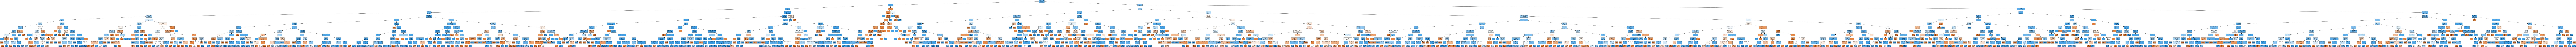

In [26]:
#from sklearn.tree import plot_tree
#plot_tree(modelDT)
# Code from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(modelDT, out_file=dot_data, filled=True, feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree.png')
Image(graph.create_png())

[Text(158.66626766906876, 209.07692307692307, 'X[19] <= 0.13\ngini = 0.251\nsamples = 55025\nvalue = [8086, 46939]'),
 Text(90.96401399667407, 192.35076923076923, 'X[0] <= 1.652\ngini = 0.129\nsamples = 31119\nvalue = [2155, 28964]'),
 Text(66.61627633037695, 175.62461538461537, 'X[1] <= -0.348\ngini = 0.12\nsamples = 30927\nvalue = [1980, 28947]'),
 Text(33.604884977827055, 158.89846153846153, 'X[1] <= -0.468\ngini = 0.24\nsamples = 10200\nvalue = [1425, 8775]'),
 Text(13.752813192904657, 142.1723076923077, 'X[14] <= 0.157\ngini = 0.456\nsamples = 995\nvalue = [350, 645]'),
 Text(6.193985587583149, 125.44615384615385, 'X[10] <= -0.216\ngini = 0.354\nsamples = 430\nvalue = [99, 331]'),
 Text(3.8818736141906878, 108.72, 'X[11] <= -0.874\ngini = 0.456\nsamples = 219\nvalue = [77, 142]'),
 Text(2.165188470066519, 91.99384615384615, 'X[3] <= 0.161\ngini = 0.322\nsamples = 109\nvalue = [22, 87]'),
 Text(1.3609756097560977, 75.2676923076923, 'X[2] <= -0.08\ngini = 0.286\nsamples = 104\nvalue

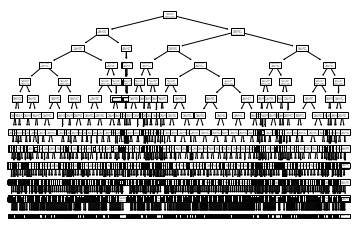

In [27]:
from sklearn.tree import plot_tree
plot_tree(modelDT)

In [28]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict(X_test)

In [29]:
# Run this block for model evaluation 
#from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))


Model Metrics
Accuracy: 0.8812280032226604
Balanced accuracy: 0.7069775469016926
Precision score for "Yes" 0.911150156710039
Recall score for "No" 0.46018465089440275


In [30]:
print(confusion_matrix(y_test, dt_pred))

[[ 1595  1871]
 [  930 19187]]


In [31]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.63      0.46      0.53      3466
        True       0.91      0.95      0.93     20117

    accuracy                           0.88     23583
   macro avg       0.77      0.71      0.73     23583
weighted avg       0.87      0.88      0.87     23583



## Random Forest Classifier

Hyperparameters:
- number of features per tree
- number of trees per forest (n_estimators)
- depth(?)

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
n_tree_grid = [50,75,100]
crit_grid = ['gini', 'entropy']
max_depth_grid = ['None', 4, 6, 8, 10, 12]
min_sample_split_grid = [2, 5, 10, 20]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

rfc_grid = {'n_estimators':n_tree_grid,
              'criterion': crit_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [44]:
forest = RandomForestClassifier()
start = time.time()
forest_cv = RandomizedSearchCV(forest, rfc_grid, cv=5)
forest_cv.fit(X_train, y)
end = time.time()
print("GridSearch time: ", end-start)

GridSearch time:  405.36047315597534


In [45]:
print("Best params: " , forest_cv.best_params_)
print("Best score: ", forest_cv.best_score_)

Best params:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy'}
Best score:  0.8789277601090413


### Max Depth for Random Forest

In [50]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = RandomForestClassifier(n_estimators=100, max_features='auto', criterion='gini', max_depth=i)
    gtree.fit(X_train, y)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = RandomForestClassifier(n_estimators=100, max_features='auto',criterion='entropy', max_depth=i)
    etree.fit(X_train, y)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

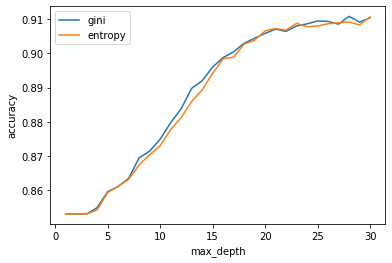

In [51]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
#plt.vlines(12, 0.855, 0.880)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Grid Search Results
- First run: n_estimators=200; min_sample_split=2; min_samples_leaf=2, max_features=10; max_depth=15; criterion='gini'
- Second run: n_estimators=50; min_sample_split=5; min_samples_leaf=25; max_features=10; max_depth=10; criterion='gini'
- Another run: n_estimators=10, split=10, leaf=5, features=12, depth=20, crit=entropy

In [36]:
# Choose default for split, leaf; use 'auto' for max features, which will default to sqrt(n_feature), 
# max_depth is half of depth of single tree (above)
modelRF = RandomForestClassifier(n_estimators = 100, max_features='auto',
                                max_depth=6, criterion='gini')
modelRF.fit(X_train, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
rf_pred = modelRF.predict(X_test)
rf_pred_prob = modelRF.predict_proba(X_test)

In [38]:
print("Random Forest Classifier model")
print("Accuracy:", metrics.accuracy_score(y_test, rf_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, rf_pred))
print('Precision score for Yes' , metrics.precision_score(y_test, rf_pred, pos_label = 1))
print('Recall score for No' , metrics.recall_score(y_test, rf_pred, pos_label = 0))

Random Forest Classifier model
Accuracy: 0.8612135860577534
Balanced accuracy: 0.5292747395996548
Precision score for Yes 0.8604382436018146
Recall score for No 0.05914598961338719


In [39]:
print(confusion_matrix(y_test, rf_pred))

[[  205  3261]
 [   12 20105]]


In [40]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

       False       0.94      0.06      0.11      3466
        True       0.86      1.00      0.92     20117

    accuracy                           0.86     23583
   macro avg       0.90      0.53      0.52     23583
weighted avg       0.87      0.86      0.81     23583

